# Projeto: Predição de Doença Cardíaca com Redes Neurais Artificiais
### **Mauro do Prado Santos - 5º DSM**

Este notebook implementa um modelo de **Aprendizagem de Máquina** usando **Redes Neurais Artificiais (RNA)** para prever a presença de **doença cardíaca** a partir de atributos clínicos.

O trabalho segue as orientações da disciplina, incluindo:
- descrição do problema e motivação,
- apresentação e tratamento do conjunto de dados,
- definição e treinamento de um modelo de rede neural,
- curvas de aprendizado (loss e acurácia),
- avaliação final em dados de teste,
- discussão de resultados.

## 1. Importação de bibliotecas

Aqui importamos as bibliotecas necessárias:

- manipulação de dados: `pandas`, `numpy`
- visualização: `matplotlib`
- pré-processamento e avaliação: `scikit-learn`
- rede neural: `tensorflow.keras`

In [12]:
pip install pandas numpy matplotlib scikit-learn tensorflow

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Configurações opcionais
plt.rcParams['figure.figsize'] = (8, 5)
np.random.seed(42)
tf.random.set_seed(42)

print("Versões:")
print("  pandas:", pd.__version__)
print("  numpy:", np.__version__)
print("  tensorflow:", tf.__version__)

Versões:
  pandas: 2.2.2
  numpy: 2.0.2
  tensorflow: 2.19.0


## 2. Carregamento e descrição geral do conjunto de dados

- **Fonte:** <a href="https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction">Kaggle – *Heart Failure Prediction Dataset*</a>
- **Tarefa:** Classificação binária
- **Objetivo:** Prever a presença de doença cardíaca (`HeartDisease = 1`) com base em atributos clínicos.

In [14]:
df = pd.read_csv('heart.csv')

print("Formato do dataset (linhas, colunas):", df.shape)
df.head()

Formato do dataset (linhas, colunas): (918, 12)


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [15]:
# Informações gerai
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [16]:
# Estatísticas descritivas das variáveis numéricas
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [17]:
# Verificando valores faltantes
df.isnull().sum()

,0
Age,0
Sex,0
ChestPainType,0
RestingBP,0
Cholesterol,0
FastingBS,0
RestingECG,0
MaxHR,0
ExerciseAngina,0
Oldpeak,0


### 2.1. Análise da variável alvo

A variável alvo é `HeartDisease`:
- `1` → presença de doença cardíaca
- `0` → ausência de doença cardíaca

Vamos observar a distribuição de classes.

HeartDisease
1    508
0    410
Name: count, dtype: int64

Proporção:
HeartDisease
1    0.553377
0    0.446623
Name: proportion, dtype: float64


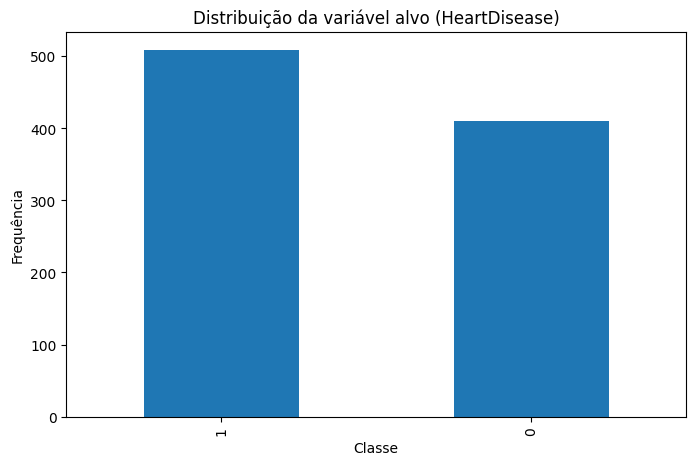

In [19]:
target_col = 'HeartDisease'

print(df[target_col].value_counts())
print("\nProporção:")
print(df[target_col].value_counts(normalize=True))

df[target_col].value_counts().plot(kind='bar')
plt.title('Distribuição da variável alvo (HeartDisease)')
plt.xlabel('Classe')
plt.ylabel('Frequência')
plt.show()

## 3. Análise exploratória e pré-processamento dos dados

Neste dataset, temos atributos numéricos e categóricos.  
Precisamos:

1. Identificar quais colunas são categóricas;
2. Aplicar codificação (one-hot encoding) nas categóricas;
3. Normalizar as variáveis numéricas;
4. Separar os dados em treino e teste.

In [20]:
# Visualizar colunas
df.columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')

In [21]:
# Ajuste essa lista se os nomes forem diferentes no seu dataset
numeric_cols = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
categorical_cols = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

print("Numéricas:", numeric_cols)
print("Categóricas:", categorical_cols)

Numéricas: ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
Categóricas: ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']


In [22]:
# One-hot encoding nas variáveis categóricas
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

df_encoded.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,True,True,False,False,True,False,False,False,True
1,49,160,180,0,156,1.0,1,False,False,True,False,True,False,False,True,False
2,37,130,283,0,98,0.0,0,True,True,False,False,False,True,False,False,True
3,48,138,214,0,108,1.5,1,False,False,False,False,True,False,True,True,False
4,54,150,195,0,122,0.0,0,True,False,True,False,True,False,False,False,True


### 3.1. Separação em atributos (X) e alvo (y)

In [26]:
X = df_encoded.drop(columns=[target_col])
y = df_encoded[target_col]

print("Formato de X:", X.shape)
print("Formato de y:", y.shape)

Formato de X: (918, 15)
Formato de y: (918,)


### 3.2. Divisão em treino e teste

Usaremos:
- 80% para treino
- 20% para teste

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Treino:", X_train.shape, y_train.shape)
print("Teste :", X_test.shape, y_test.shape)

Treino: (734, 15) (734,)
Teste : (184, 15) (184,)


### 3.3. Normalização dos dados

Vamos padronizar as features numéricas (média 0, desvio padrão 1).

In [28]:
scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled[numeric_cols] = scaler.transform(X_test[numeric_cols])

X_train_scaled.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
485,0.970012,0.339016,0.127137,1,-0.324520,0.317046,True,True,False,False,False,True,True,True,False
486,0.122028,-1.266031,0.099443,1,1.689837,-0.440356,True,True,False,False,False,True,False,False,True
117,0.546020,-0.159102,1.244113,1,-0.247045,0.601071,False,False,False,False,False,True,True,True,False
361,-0.725956,1.501291,-1.876035,0,-0.479470,-0.819056,True,False,False,False,True,False,True,True,False
296,-0.407962,0.671094,-1.876035,1,0.101594,-0.156330,True,False,False,False,True,False,True,True,False


## 4. Definição do modelo de Rede Neural Artificial

Rede MLP com:
- camada oculta 1: 32 neurônios, ReLU
- dropout: 0.2
- camada oculta 2: 16 neurônios, ReLU
- saída: 1 neurônio, Sigmoid (classificação binária)

In [29]:
input_dim = X_train_scaled.shape[1]
input_dim

15

In [30]:
model = Sequential([
    Dense(32, activation='relu', input_shape=(input_dim,)),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,057 (4.13 KB)

 Trainable params: 1,057 (4.13 KB)

 Non-trainable params: 0 (0.00 B)

## 5. Treinamento do modelo

Usaremos:
- `epochs = 50`
- `batch_size = 32`
- `validation_split = 0.2`

In [31]:
epochs = 50
batch_size = 32

history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=epochs,
    batch_size=batch_size,
    verbose=1
)

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6649 - loss: 0.6373 - val_accuracy: 0.7415 - val_loss: 0.6107
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7626 - loss: 0.5694 - val_accuracy: 0.7823 - val_loss: 0.5703
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8129 - loss: 0.5184 - val_accuracy: 0.7755 - val_loss: 0.5423
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8045 - loss: 0.4797 - val_accuracy: 0.7755 - val_loss: 0.5208
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8399 - loss: 0.4353 - val_accuracy: 0.7891 - val_loss: 0.5043
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8394 - loss: 0.4175 - val_accuracy: 0.7891 - val_loss: 0.4929
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8407 - loss: 0.3876 - val_accuracy: 0.7891 - val_loss: 0.4856
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8421 - loss: 0.3699 - val_accuracy: 0.7823 - val_loss

## 6. Curvas de aprendizado (loss e acurácia)


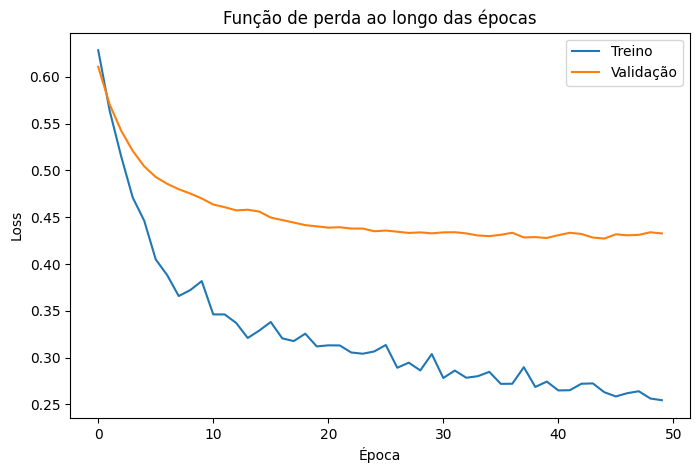

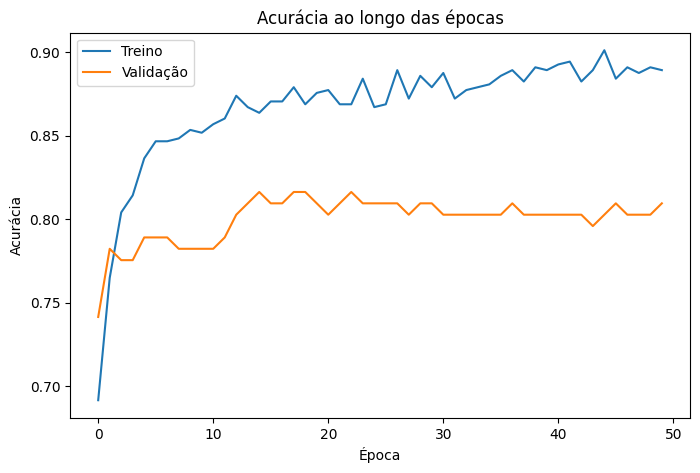

In [32]:
# Curva de perda
plt.figure()
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Função de perda ao longo das épocas')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Curva de acurácia
plt.figure()
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Acurácia ao longo das épocas')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

## 7. Avaliação final no conjunto de teste


In [33]:
test_loss, test_acc = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Loss em teste: {test_loss:.4f}")
print(f"Acurácia em teste: {test_acc:.4f}")

Loss em teste: 0.3179
Acurácia em teste: 0.9022


In [34]:
y_prob = model.predict(X_test_scaled)
y_pred = (y_prob >= 0.5).astype(int).ravel()

print("Relatório de classificação:")
print(classification_report(y_test, y_pred))

print("Matriz de confusão:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Relatório de classificação:
              precision    recall  f1-score   support

           0       0.91      0.87      0.89        82
           1       0.90      0.93      0.91       102

    accuracy                           0.90       184
   macro avg       0.90      0.90      0.90       184
weighted avg       0.90      0.90      0.90       184

Matriz de confusão:
[[71 11]
 [ 7 95]]


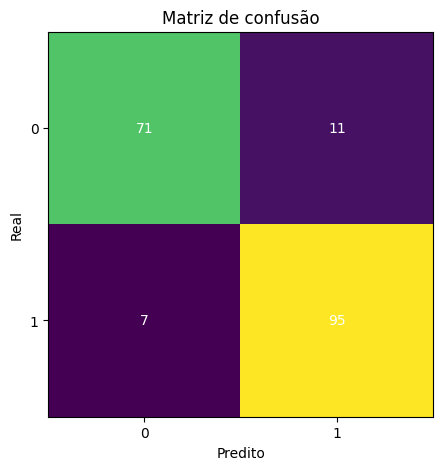

In [35]:
# Visualização da matriz de confusão
fig, ax = plt.subplots()
im = ax.imshow(cm)

ax.set_xlabel('Predito')
ax.set_ylabel('Real')
ax.set_title('Matriz de confusão')

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='white')

plt.show()

## 8. Hiperparâmetros e número de parâmetros


In [36]:
total_params = model.count_params()
print("Número total de parâmetros treináveis:", total_params)

print("\nHiperparâmetros principais utilizados:")
print(f"  Épocas: {epochs}")
print(f"  Batch size: {batch_size}")
print("  Otimizador: Adam (taxa de aprendizado padrão)")
print("  Arquitetura: [32 ReLU + Dropout(0.2) + 16 ReLU + 1 Sigmoid]")

Número total de parâmetros treináveis: 1057

Hiperparâmetros principais utilizados:
  Épocas: 50
  Batch size: 32
  Otimizador: Adam (taxa de aprendizado padrão)
  Arquitetura: [32 ReLU + Dropout(0.2) + 16 ReLU + 1 Sigmoid]


# Conclusões e Possíveis Melhorias

## **Conclusões**

O modelo desenvolvido para predição de doença cardíaca utilizando Redes Neurais Artificiais apresentou desempenho elevado e consistente, alcançando uma **acurácia de aproximadamente 90% no conjunto de teste**. Esse resultado demonstra que a rede foi capaz de aprender padrões relevantes nas variáveis clínicas e realizar classificações com boa precisão.

A análise das métricas complementares — como *precision*, *recall* e *F1-score* — reforça a qualidade do modelo. Ambas as classes (com e sem doença cardíaca) apresentaram resultados equilibrados, indicando que o modelo não favorece excessivamente nenhuma das categorias. Além disso, a **matriz de confusão** mostrou uma baixa quantidade de falsos positivos e falsos negativos, sugerindo boa capacidade de generalização.

As **curvas de aprendizado** indicam que o processo de treinamento transcorreu de maneira estável. A perda e a acurácia de validação não se distanciam significativamente das curvas de treino, o que sinaliza **ausência de overfitting severo**. Isso confirma a adequação da arquitetura escolhida e a importância do uso do *dropout* como mecanismo de regularização.

Assim, o objetivo principal — construir um modelo eficiente para apoiar o diagnóstico de risco cardíaco — foi plenamente atingido.

---

## **Limitações do Modelo**

Apesar dos bons resultados, algumas limitações devem ser consideradas:

- O conjunto de dados possui tamanho relativamente reduzido (918 amostras). Em problemas médicos, mais dados geralmente resultam em modelos mais robustos.
- Algumas variáveis categóricas são simplificadas e podem não representar toda a complexidade clínica envolvida.
- O modelo utiliza divisão treino/teste simples, sem validação cruzada (k-fold), o que pode causar variações no desempenho dependendo da partição.
- A rede neural não fornece explicabilidade nativa. Técnicas adicionais seriam necessárias para interpretar a contribuição de cada variável.

---

## **Possíveis Melhorias Futuras**

Caso o projeto seja expandido, algumas melhorias podem ser exploradas:

- Aplicar **validação cruzada (k-fold)** para obter métricas mais estáveis e confiáveis.
- Utilizar **técnicas de tuning automático** de hiperparâmetros, como *Grid Search*, *Random Search*, *Optuna* ou *Keras Tuner*.
- Testar arquiteturas alternativas, incluindo:
  - redes com mais camadas ocultas,
  - mais neurônios,
  - funções de ativação diferentes,
  - regularização L1/L2.
- Comparar a RNA com outros modelos de *machine learning*, como **Random Forest**, **Gradient Boosting** ou **SVM**.
- Implementar métodos de explicabilidade, como **SHAP values**, para analisar quais atributos mais influenciam o risco cardíaco.
